# Machine Learning with Python

## Exemple : Location de vélos

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* **datetime** : hourly date + timestamp  
* **season** : 1 = spring, 2 = summer, 3 = fall, 4 = winter 
* **holiday** : whether the day is considered a holiday
* **workingday** : whether the day is neither a weekend nor holiday
* **weather** : 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* **temp** : temperature in Celsius
* **atemp** : "feels like" temperature in Celsius
* **humidity** : relative humidity
* **windspeed** : wind speed
* **casual** : number of non-registered user rentals initiated
* **registered** : number of registered user rentals initiated
* **count** : number of total rentals (Dependent Variable)

In [0]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

### Déroulé des questions : 

**Partie 1 exploration et visualisation des données**
1. Lire le dataset vlib.csv et décrire rapidement le dataset (nombre de ligne, colonne, types des variables)
2. Etudier les types des données, peux-t-on trouver un schéma de donner plus judicieux 
3. Etudier la variable datetime, quelles features peut-t-on créer/extraire avec cette variable ? Créer ces variables
4. Changer la structure des données pour que les variables qui sont catégorielles soient considérés comme tels
5. Catégoriser les outliers de la population du label ==> Proposer un petit script pour retirer les outliers de la population (hors de la limite [-3*std , + 3* std]. Combien d'outliers à-t-on filtré ?
6. Etudier les corrélations entre les différentes variables grâce à la fonction, Quelles variables sont très corrélées ? Visualiser ces corrélations grâce à la fonction heatmap de seaborn.
7. Visualisation des données : Peut-on visualiser la distribution du nombre de vélos loués par jour en fonction de l'heure de la journée, quels sont les pics ? Vérifier que les gens louent plus de vélos en été.

Bonus : Quelle est la différence au niveau des distributions de registered et de casual ?

Indice sur amélioration : La colonne windspeed ? Quels remarque pouvons nous faire ? Quelle technique pouvons nous employer pour corriger les données ? 

** Partie 2 modélisation**

1. Verifier votre dataset et si besoin, créer de nouvelles features, verifier leur type et supprimer les variables inutiles. 
2. Randomiser les données et séparer le jeu de données. Verifier la taille de vos 2 sous ensembles train / test.
3. Tester un premier modèle simple : la régression linéaire. Choisissez votre metrique et analyser les résultats. Faire un graphe. **BONUS** : Utiliser la librarie statsmodels et afficher un summary de la régression.
4. Choisir les modèles à tester. Effectuer un GridSearch et une cross-validation (avec K=5) pour chacun des modèles choisi. Afficher les meilleurs paramètres pour chacun des modèles ainsi que les résultats sur le sous ensemble train. 
5. Conclure. Identifier le meilleur modèle et ré-entrainer le modèle avec ses paramètres optimaux. Afficher les résultats sur le sous ensemble de test.

### Corrigé

## Partie 1 : Visualisation et feature engineering

This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way 

 - About Dataset
 - Data Summary
 - Feature Engineering
 - Missing Value Analysis
 - Outlier Analysis
 - Correlation Analysis
 - Visualizing Distribution Of Data
 - Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
 - Filling 0's In Windspeed Using Random Forest
 - Linear Regression Model
 - Regularization Models
 - Ensemble Models

### Question 1
Lire le dataset vlib.csv et décrire rapidement le dataset (nombre de ligne, colonne, types des variables)

In [2]:
### Question 1
#Lire le dataset vlib.csv et décrire rapidement le dataset (nombre de ligne, colonne, types des variables)

dailyData = pd.read_csv("data/vlib.csv")

FileNotFoundError: ignored

In [0]:
dailyData[['count', 'registered', 'casual']].head(3)

,count,registered,casual
0,16,13,3
1,40,32,8
2,32,27,5


### Question 2 :
Etudier les types des données, peux-t-on trouver un schéma de donner plus judicieux ? Si oui transformer le dataset en prenant en compte les nouveaux types de features.

In [0]:
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


### Question 3 :
Etudier la variable datetime, quelles features peut-t-on créer/extraire avec cette variable ? Créer ces variables

In [0]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [0]:
dictionnaire_saisons = {1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" }

In [0]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split(" ")[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : 
                                            calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : 
                                          calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map(dictionnaire_saisons)
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [0]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


### Question 4 :
Transformer les variables qui devraient être catégorielles en variables catégorielles en utilisations pandas

In [0]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [0]:
dailyData  = dailyData.drop(["datetime"],axis=1)

### Question 5
Catégoriser les outliers de la population du label ==> 
Proposer un petit script pour visualiser les outliers sur la variable count.
Proposer une méthode pour filtrer ces données anormales (Par exemple en utilisant la variance de la distribution). Combien d'outliers à-t-on filtré ?

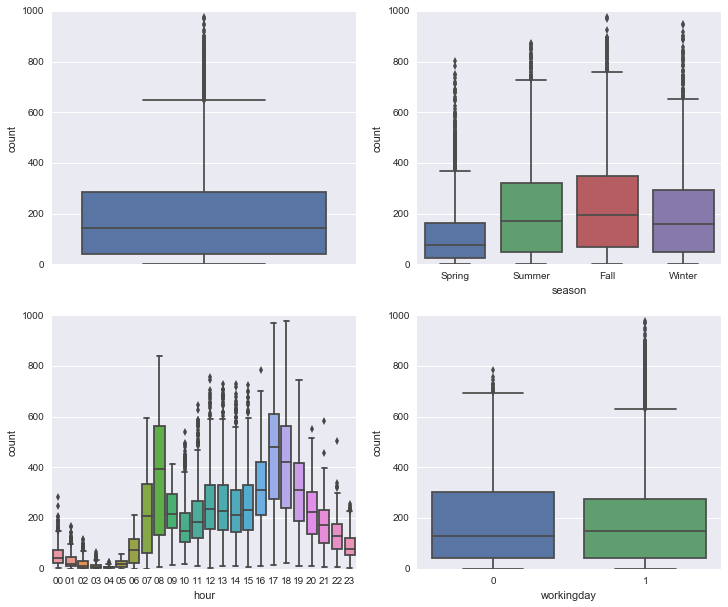

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [0]:
dailyData[
    np.abs(dailyData["count"] - dailyData["count"].mean()) <= (3 * dailyData["count"].std())
]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0000,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0000,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0000,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0000,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0000,0,1,1,2011-01-01,04,Saturday,January
5,2011-01-01 05:00:00,Spring,0,0,"Mist + Cloudy, Mist + Broken clouds, Mist + F...",9.84,12.880,75,6.0032,0,1,1,2011-01-01,05,Saturday,January
6,2011-01-01 06:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0000,2,0,2,2011-01-01,06,Saturday,January
7,2011-01-01 07:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,8.20,12.880,86,0.0000,1,2,3,2011-01-01,07,Saturday,January
8,2011-01-01 08:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0000,1,7,8,2011-01-01,08,Saturday,January
9,2011-01-01 09:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,13.12,17.425,76,0.0000,8,6,14,2011-01-01,09,Saturday,January


In [0]:
dailyDataWithoutOutliers = dailyData[
    np.abs(dailyData["count"] - dailyData["count"].mean()) <= (3 * dailyData["count"].std())
] 

In [0]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


### Question 6
Etudier les corrélations entre les différentes variables grâce à la fonction, Quelles variables sont très corrélées ? Visualiser ces corrélations grâce à la fonction heatmap de seaborn.

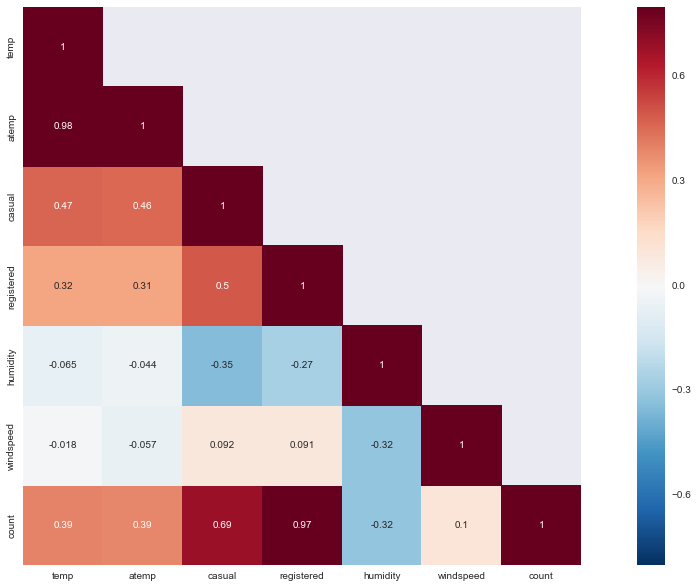

In [0]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

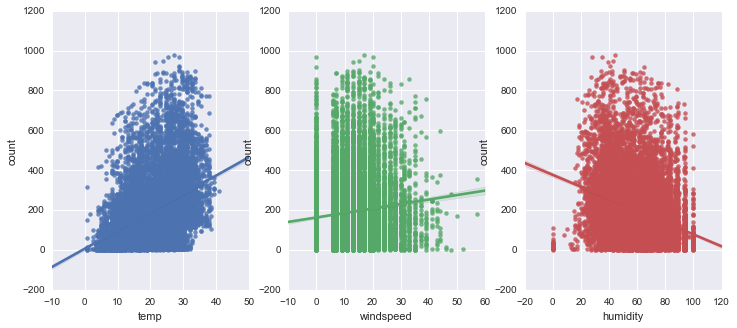

In [0]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

### Question 7 et bonus


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229778, 4.5624238680878078, 0.95811767809096149))

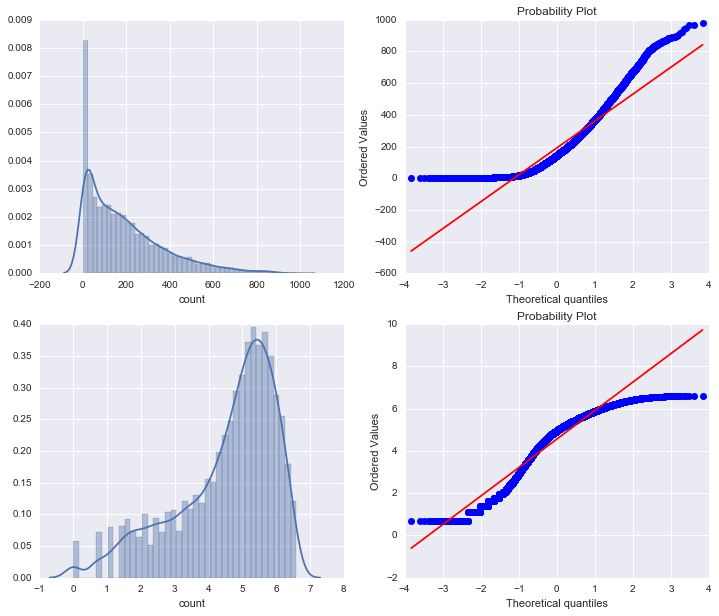

In [0]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

 None]

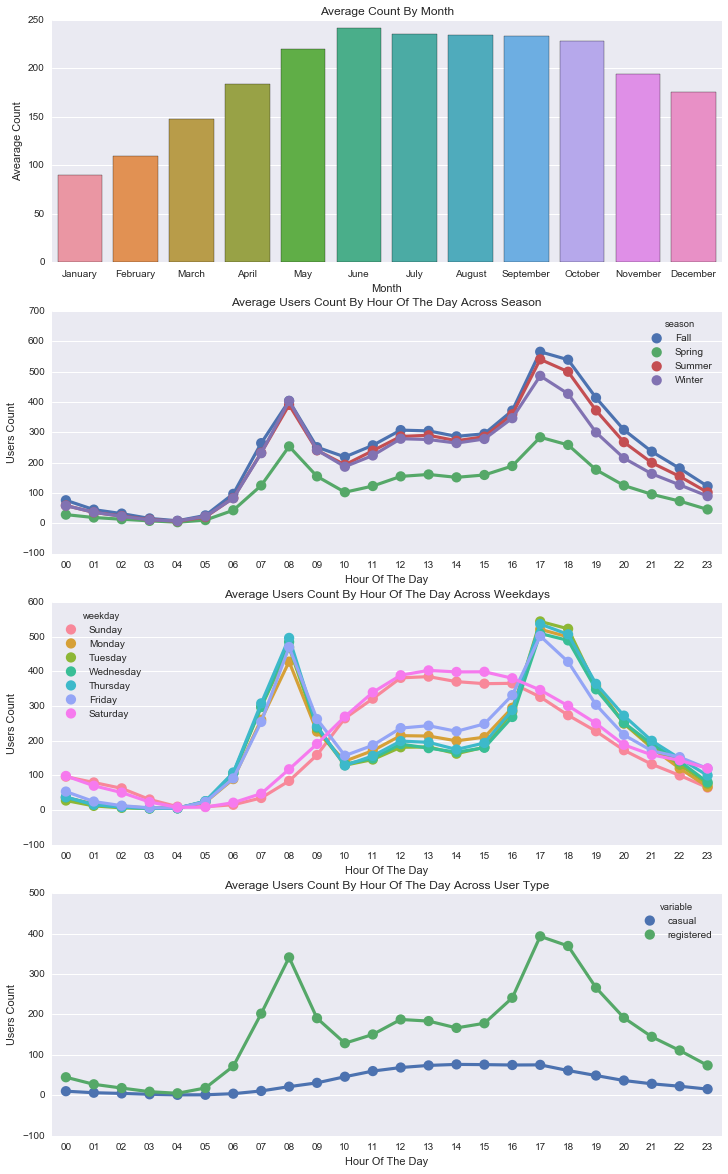

In [0]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

## Partie 2 : Modélisation

### Question 1 
Verifier votre dataset et si besoin, créer de nouvelles features, verifier leur type et supprimer les variables inutiles.

In [0]:
data = pd.read_csv("data/vlib.csv")

In [0]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [0]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ["casual","datetime","date","registered"]

In [0]:
data = data.drop(dropFeatures, axis=1)

In [0]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [0]:
# BONUS : if you want to dummify features
# data = pd.get_dummies(data,columns=["holiday"])

### Question 2 
Randomiser les données et séparer le jeu de données. Verifier la taille de vos 2 sous ensembles train / test.

In [0]:
# Shuffle data using random seed 
random_seed = 42
data = data.sample(frac=1, random_state=random_seed)
data.reset_index(inplace=True, drop=True)

In [0]:
import sklearn 
sklearn.__version__

'0.18.1'

In [0]:
from sklearn.model_selection import train_test_split

X = data.drop('count', axis=1)
Y = data['count']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [0]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8708, 12) (2178, 12)
(8708,) (2178,)


### Question 3
Tester un premier modèle simple : la régression linéaire. 
Choisissez votre metrique et analyser les résultats. Faire un graphe. 

**BONUS** : Utiliser la librarie statsmodels et afficher un summary de la régression.

In [0]:
from sklearn.linear_model import LinearRegression

lModel = LinearRegression()
lModel.fit(X=X_train, y=Y_train)

preds = lModel.predict(X= X_train)

np.sqrt(metrics.mean_squared_error(Y_train, preds))

140.47104880854016

In [0]:
from sklearn.linear_model import LinearRegression

lModel = LinearRegression()
lModel.fit(X=X_train, y=Y_train)

preds = lModel.predict(X= X_test)

np.sqrt(metrics.mean_squared_error(Y_test, preds))


145.97553029951604

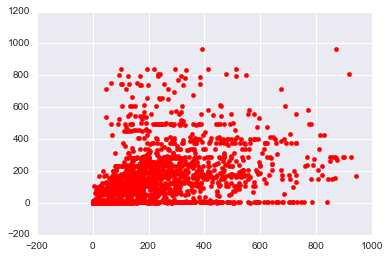

In [0]:
from sklearn.linear_model import LogisticRegression

lModel = LogisticRegression()
lModel.fit(X=X_train, y=Y_train)

preds = lModel.predict(X= X_test)

np.sqrt(metrics.mean_squared_error(Y_test, preds))
plt.scatter(Y_test, preds, color='red')

In [0]:
# define metric RMSE
def rmse(y, y_):
    return np.sqrt(np.mean((y-y_)**2))

def mae(y, y_):
    return np.mean(np.abs(y-y_))

RMSE Value For Linear Regression:  145.9755303
MAE Value For Linear Regression:  107.86625773142906
Coefficients: 
 [ -9.23167803   6.25376574   4.82207069  -3.81449415   1.9858265
   4.34100946  -2.08800665   0.62781113   7.62948716  81.18780769
   2.05667535  10.59593918]
Mean squared error: 145
R2 score: 0.39


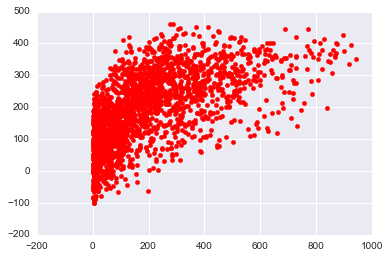

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X=X_train, y=Y_train)

# Make predictions
preds = lModel.predict(X= X_test)
print ("RMSE Value For Linear Regression: ", rmse(Y_test, preds))
print ("MAE Value For Linear Regression: ", mae(Y_test, preds))

# Coefficients
print('Coefficients: \n', lModel.coef_)
# The mean squared error
print("Mean squared error: %i"
      % np.sqrt(metrics.mean_squared_error(Y_test, preds)))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % metrics.r2_score(Y_test, preds))

# Plot outputs
plt.scatter(Y_test, preds, color='red')

** Bonus **

In [0]:
import statsmodels.api as sm

# Features must be numeric
results = sm.OLS(np.asarray(Y_train),sm.add_constant(np.asarray(X_train[["temp", "humidity", "windspeed"]]))).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     899.1
Date:                Wed, 18 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:59:26   Log-Likelihood:                -56426.
No. Observations:                8708   AIC:                         1.129e+05
Df Residuals:                    8704   BIC:                         1.129e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        175.4975      8.824     19.889      0.0

### Question 4 : Sélection de modèle
Choisir les modèles à tester. 
Effectuer un GridSearch et une cross-validation (avec K=5) pour chacun des modèles choisi.

Afficher les meilleurs paramètres pour chacun des modèles ainsi que les résultats sur le sous ensemble train. 

** Cross-Validation for Linear Regression **

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

lm = LinearRegression()
rmsle_scorer = metrics.make_scorer(rmse, greater_is_better=False)

# Train the model with 10-folds
# Warning : without `scoring` parameter it returns a R2 score ! 
scores = cross_val_score(lm, X_train, Y_train, cv=10, scoring=rmsle_scorer) 
print("Cross-validated scores:", -scores)

# Make predictions
predictions = cross_val_predict(lm, X_train, Y_train, cv=10)

Cross-validated scores: [ 138.96929347  134.12012507  137.89309527  150.15196118  141.84169593
  136.84300287  145.85206012  138.88277825  144.70621075  137.124856  ]


In [0]:
np.mean(scores)

-140.63850789007145

** GridSearch for Ridge Regression **

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn.linear_model import Ridge

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0, 25, 30,35, 40, 50, 60, 70, 100]}
rmsle_scorer = metrics.make_scorer(rmse, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_, 
                            ridge_params_, 
                            scoring = rmsle_scorer,
                            cv=5)

grid_ridge_m.fit(X_train, Y_train)
preds = grid_ridge_m.predict(X=X_train)
print ("Best parameters:", grid_ridge_m.best_params_)
print ("RMSE Value For Ridge Regression: ", rmse(Y_train, preds))
print ("MAE Value For Linear Regression: ", mae(Y_train, preds))

Best parameters: {'max_iter': 3000, 'alpha': 50}
RMSE Value For Ridge Regression:  140.474514276
MAE Value For Linear Regression:  105.18027288072994


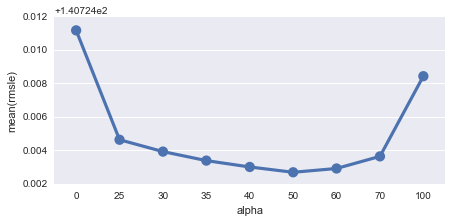

In [0]:
# Plot scores
fig,ax= plt.subplots()
fig.set_size_inches(7,3)
df = pd.DataFrame(grid_ridge_m.cv_results_)[['params','mean_test_score','mean_train_score']]
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

** GridSearch for Lasso Regression **

In [0]:
from sklearn.linear_model import Lasso

lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}
grid_lasso_m = GridSearchCV(lasso_m_,
                            lasso_params_,
                            scoring = rmsle_scorer,
                            cv=5)

grid_lasso_m.fit(X_train, Y_train)
preds = grid_lasso_m.predict(X=X_train)
print ("Best parameters:", grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmse(Y_train, preds))
print ("MAE Value For Linear Regression: ", mae(Y_train, preds))

Best parameters: {'max_iter': 3000, 'alpha': 1.0}
RMSLE Value For Lasso Regression:  140.525951175
MAE Value For Linear Regression:  105.07070734668324


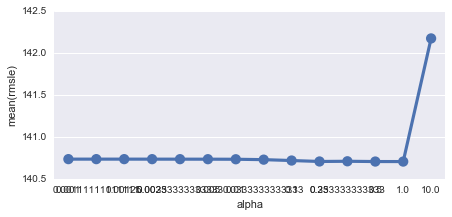

In [0]:
# Plot scores
fig,ax= plt.subplots()
fig.set_size_inches(7,3)
df = pd.DataFrame(grid_lasso_m.cv_results_)[['params','mean_test_score','mean_train_score']]
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

** GridSearch for Random Forest **

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_Model = RandomForestRegressor()

rf_params = { 'n_estimators':[10, 50, 100],'max_depth':[3,5,7]}
grid_rf_m = GridSearchCV(rf_Model, 
                         rf_params, 
                         scoring=rmsle_scorer, 
                         cv=5)

grid_rf_m.fit(X_train, Y_train)
preds = grid_rf_m.predict(X=X_train)
print ("Best parameters:", grid_rf_m.best_params_)
print ("RMSLE Value For Random Forest: ",rmse(Y_train, preds))
print ("MAE Value For Linear Regression: ", mae(Y_train, preds))

Best parameters: {'n_estimators': 100, 'max_depth': 7}
RMSLE Value For Random Forest:  73.8943846442
MAE Value For Linear Regression:  48.13613770958783


** GridSearch for Gradient Boosting **

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()

gbm_params = { 'n_estimators':[100, 1000, 4000], 'alpha':[0.01, 0.1]}
grid_gbm = GridSearchCV(gbm, 
                        gbm_params, 
                        scoring=rmsle_scorer, 
                        cv=5)

grid_gbm.fit(X_train, Y_train)
preds = grid_gbm.predict(X=X_train)
print ("Best parameters:", grid_gbm.best_params_)
print ("RMSLE Value For Gradient Boosting: ",rmse(Y_train, preds))

Best parameters: {'alpha': 0.1, 'n_estimators': 4000}
RMSLE Value For Gradient Boosting:  39.1044686871


### Question 5 : Conclusion
Identifier le meilleur modèle et ré-entrainer le modèle avec ses paramètres optimaux. 

Afficher les résultats sur le sous ensemble de test.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X=X_train, y=Y_train)

# Make predictions
preds = lModel.predict(X= X_test)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X_train, Y_train, cv=10)
from sklearn import tree

/Users/albertoguggiola/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [0]:
tree.export_graphviz(clf, out_file='tree.dot')       

AttributeError: 'NoneType' object has no attribute 'children_left'